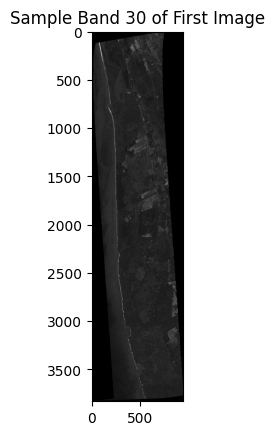

In [1]:
import spectral
import numpy as np
import matplotlib.pyplot as plt

# List of paths to .hdr files
hdr_files = [
    r"C:\21261A3234\Projects\mini\Datasets\AVIRIS_2021 flight lines\f100506t01p00r08\f100506t01p00r08rdn_b\f100506t01p00r08rdn_b_sc01_ort_img.hdr",
    r"C:\21261A3234\Projects\mini\Datasets\AVIRIS_2021 flight lines\f111116t01p00r19\f111116t01p00r19rdn_c\f111116t01p00r19rdn_c_sc01_ort_img.hdr",
    r"C:\21261A3234\Projects\mini\Datasets\AVIRIS_2021 flight lines\f121020t01p00r06\f121020t01p00r06rdn_a\f121020t01p00r06rdn_a_sc01_ort_img.hdr"
]

# Load the images
images = [spectral.open_image(hdr) for hdr in hdr_files]

# Display the first image, selecting an arbitrary band (e.g., band 30)
sample_image = images[0].load()
plt.imshow(sample_image[:, :, 30], cmap='gray')
plt.title("Sample Band 30 of First Image")
plt.show()


In [3]:
def normalize_image(image):
    # Normalize each band to the range [0, 1]
    normalized_image = (image - image.min()) / (image.max() - image.min())
    return normalized_image

# Normalize the first image as an example
normalized_image = normalize_image(sample_image)


In [5]:
def image_to_patches(image, patch_size=16):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch)
    return np.array(patches)

# Convert the normalized image into patches
patches = image_to_patches(normalized_image)
print("Number of patches:", patches.shape)


Number of patches: (14101, 16, 16, 224)


In [7]:
import torch
import torch.utils.data as data

class HyperspectralDataset(data.Dataset):
    def __init__(self, patches):
        self.patches = torch.tensor(patches, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return self.patches.shape[0]

    def __getitem__(self, idx):
        return self.patches[idx], self.patches[idx]

# Initialize dataset and dataloader
dataset = HyperspectralDataset(patches)
dataloader = data.DataLoader(dataset, batch_size=16, shuffle=True)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(224, 128, 3, stride=2, padding=1),  # Input channels = bands
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 224, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# Initialize a list to store loss history
loss_history = []

# Training loop
epochs = 50
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())  # Save the loss for this epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 1/50, Loss: 0.001063224975951016
Epoch 2/50, Loss: 0.0006805500597693026
Epoch 3/50, Loss: 0.000819600943941623
Epoch 4/50, Loss: 0.00031817768467590213
Epoch 5/50, Loss: 0.0007971989107318223
Epoch 6/50, Loss: 0.000871119205839932
Epoch 7/50, Loss: 0.0005189867224544287
Epoch 8/50, Loss: 0.0008103291620500386
Epoch 9/50, Loss: 0.0011298662284389138
Epoch 10/50, Loss: 0.0013288924237713218
Epoch 11/50, Loss: 0.0009801615960896015
Epoch 12/50, Loss: 0.0007868217071518302
Epoch 13/50, Loss: 0.0005733203724958003
Epoch 14/50, Loss: 0.0002522444410715252
Epoch 15/50, Loss: 0.0008178051793947816
Epoch 16/50, Loss: 0.0008656156132929027
Epoch 17/50, Loss: 0.0009132804698310792
Epoch 18/50, Loss: 0.0011707523372024298
Epoch 19/50, Loss: 0.0007394706481136382
Epoch 20/50, Loss: 0.0007022691424936056
Epoch 21/50, Loss: 0.0008078770479187369
Epoch 22/50, Loss: 0.00046095644938759506
Epoch 23/50, Loss: 0.0007181639084592462
Epoch 24/50, Loss: 0.0007493364391848445
Epoch 25/50, Loss: 0.00084

NameError: name 'pickle' is not defined

In [37]:
import torch
import pickle

# Define a function to save model and other variables
def save_training_state(model, optimizer, loss_history):
    # Save the model state
    torch.save(model.state_dict(), 'model_weights.pth')
    
    # Save the optimizer state
    torch.save(optimizer.state_dict(), 'optimizer_state.pth')
    
    # Save the loss history
    with open('loss_history.pkl', 'wb') as f:
        pickle.dump(loss_history, f)

# Call the save function at the end of your training loop
save_training_state(model, optimizer, loss_history)


In [11]:
import torch
import pickle
import warnings

# Define a function to load the model, optimizer, and loss history
def load_training_state(model, optimizer):
    # Load the model state with `weights_only=True`
    model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
    
    # Suppress the specific warning temporarily for loading optimizer state
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        optimizer.load_state_dict(torch.load('optimizer_state.pth'))
    
    # Load the loss history
    with open('loss_history.pkl', 'rb') as f:
        loss_history = pickle.load(f)
    
    return model, optimizer, loss_history

# Example usage:
model, optimizer, loss_history = load_training_state(model, optimizer)


In [13]:
from skimage.metrics import structural_similarity as ssim
import torch
import numpy as np

def evaluate_autoencoder(dataloader, model):
    model.eval()  # Set model to evaluation mode
    mse_losses = []
    ssim_scores = []

    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            outputs = model(inputs)

            # Calculate MSE per batch using PyTorch
            mse_loss = ((outputs - inputs) ** 2).mean().item()
            mse_losses.append(mse_loss)

            # Calculate SSIM per patch
            for i in range(inputs.size(0)):
                original = inputs[i].cpu().numpy().transpose(1, 2, 0)
                reconstructed = outputs[i].cpu().numpy().transpose(1, 2, 0)
                ssim_score = ssim(original, reconstructed, data_range=1.0, multichannel=True)
                ssim_scores.append(ssim_score)

    # Calculate average MSE and SSIM for final evaluation
    avg_mse = np.mean(mse_losses)
    avg_ssim = np.mean(ssim_scores)
    print(f'Evaluation MSE: {avg_mse}')
    print(f'Evaluation SSIM: {avg_ssim}')
    return avg_mse, avg_ssim

# Run evaluation on the test set
avg_mse, avg_ssim = evaluate_autoencoder(dataloader, model)


Evaluation MSE: 0.0007344812086201008
Evaluation SSIM: 0.6198693162945919


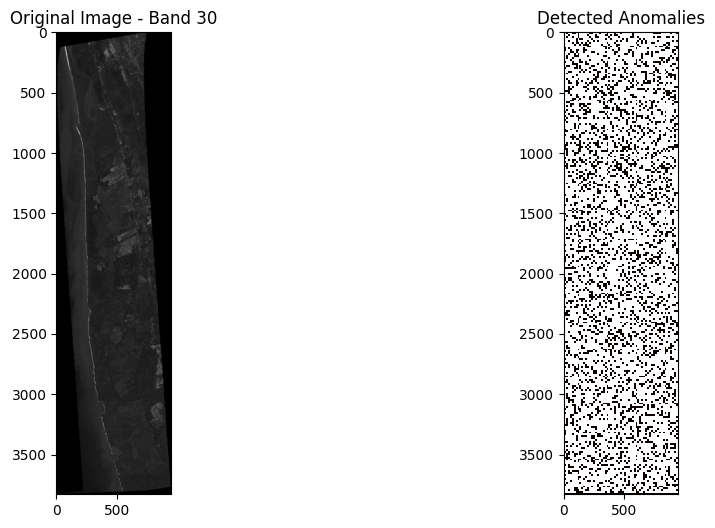

In [13]:
def calculate_anomalies(dataloader, model, threshold=0.01):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)

            # Ensure outputs and inputs have matching shapes for MSE calculation
            if outputs.shape != inputs.shape:
                outputs = torch.nn.functional.interpolate(outputs, size=inputs.shape[2:], mode='bilinear', align_corners=False)

            # Calculate the per-patch loss
            losses = ((outputs - inputs) ** 2).mean(dim=[1, 2, 3])  # Mean squared error per patch
            anomaly_scores.extend(losses.cpu().numpy())  # Collect scores for each patch

    # Normalize the anomaly scores to range [0, 1]
    anomaly_scores = np.array(anomaly_scores)
    anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    
    # Return a boolean array where True indicates an anomaly
    return anomaly_scores > threshold

# Calculate anomalies for patches
anomalies = calculate_anomalies(dataloader, model)

def visualize_anomalies_with_original(image, anomalies, patch_size=16):
    h, w, _ = image.shape
    anomaly_image = np.zeros((h, w))

    patch_idx = 0
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            if anomalies[patch_idx]:
                anomaly_image[i:i + patch_size, j:j + patch_size] = 1  # Mark anomaly
            patch_idx += 1

    plt.figure(figsize=(12, 6))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, 30], cmap='gray')
    plt.title("Original Image - Band 30")

    # Show anomaly map
    plt.subplot(1, 2, 2)
    plt.imshow(anomaly_image, cmap='hot', interpolation='nearest')
    plt.title("Detected Anomalies")

    plt.show()

# Visualize the anomalies with the original image
visualize_anomalies_with_original(sample_image, anomalies)



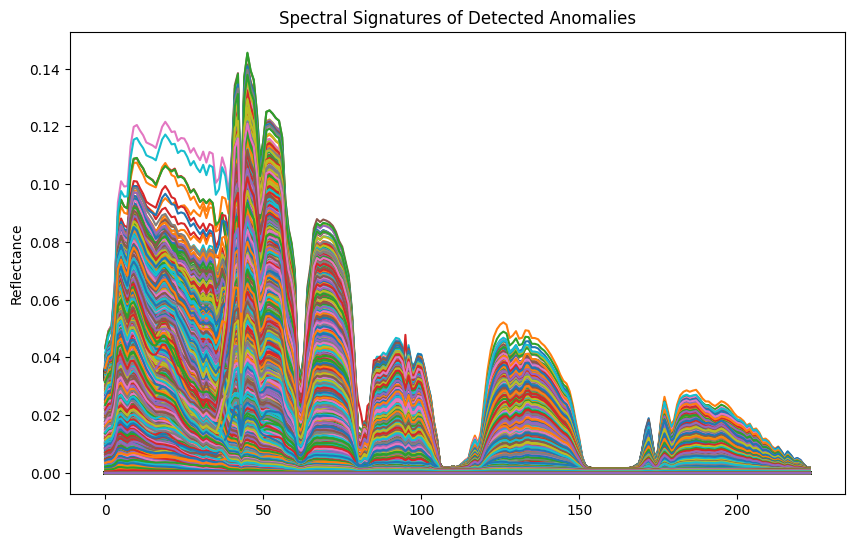

In [15]:
def extract_spectral_signatures(anomalies, image, patch_size=16):
    """
    Extracts the spectral signatures of patches identified as anomalies.

    Parameters:
    - anomalies: Boolean array where True indicates an anomaly patch.
    - image: The original hyperspectral image (normalized).
    - patch_size: Size of each patch (default is 16).

    Returns:
    - spectral_signatures: A list containing the spectral signature of each anomaly.
    """
    h, w, bands = image.shape
    spectral_signatures = []
    patch_idx = 0

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            if anomalies[patch_idx]:
                # Extract the patch and calculate the mean spectral signature
                patch = image[i:i + patch_size, j:j + patch_size, :]
                mean_spectral_signature = patch.mean(axis=(0, 1))  # Average over spatial dimensions
                spectral_signatures.append(mean_spectral_signature)
            patch_idx += 1

    return spectral_signatures

# Extract spectral signatures for anomalies
spectral_signatures = extract_spectral_signatures(anomalies, normalized_image)

def plot_spectral_signatures(spectral_signatures):
    plt.figure(figsize=(10, 6))
    for signature in spectral_signatures:
        plt.plot(signature)
    plt.xlabel("Wavelength Bands")
    plt.ylabel("Reflectance")
    plt.title("Spectral Signatures of Detected Anomalies")
    plt.show()

# Plot the spectral signatures of anomalies
plot_spectral_signatures(spectral_signatures)


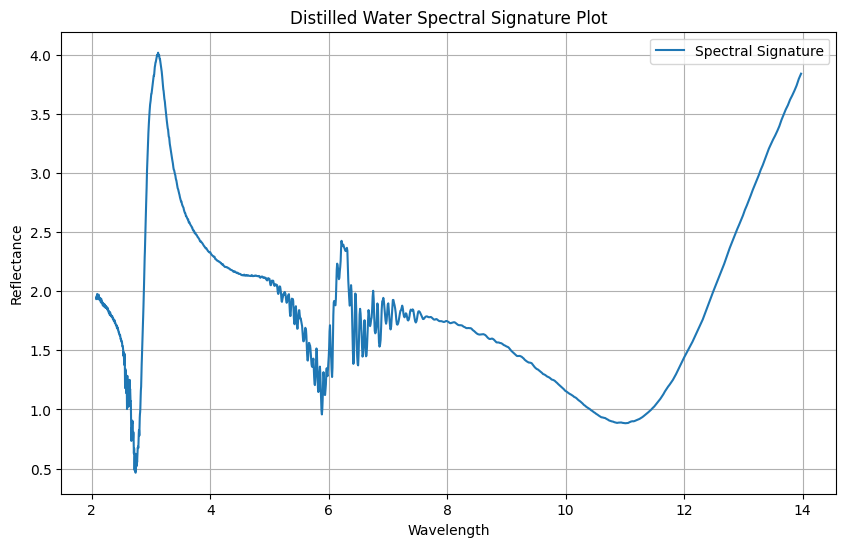

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Specify the path to your spectrum file
file_path = r"C:\21261A3234\Projects\mini\Datasets\ecospeclib_1730360875648\ecospeclib-all\water.distilledwater.none.liquid.tir.distwatr.jhu.becknic.spectrum.txt"

# Define the number of header lines to skip (assuming the metadata ends after 22 lines)
header_lines = 22

# Load data, skipping header lines and assuming the file is tab-separated
data = pd.read_csv(file_path, sep='\t', skiprows=header_lines, header=None, names=['Wavelength', 'Reflectance'])

# Save the library signature to a variable
library_signature = data

# Save the library signature to a .pickle file for future use
with open('library_signature.pkl', 'wb') as f:
    pickle.dump(library_signature, f)

# Plotting reflectance vs. wavelength
plt.figure(figsize=(10, 6))
plt.plot(data['Wavelength'], data['Reflectance'], label='Spectral Signature')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Distilled Water Spectral Signature Plot')
plt.legend()
plt.grid(True)
plt.show()



In [19]:
import numpy as np
import pandas as pd
import pickle

# Load the saved library signature with wavelengths and reflectance values
with open('library_signature.pkl', 'rb') as f:
    library_signature_df = pickle.load(f)

# Extract only the Reflectance values and convert to a 1D array
library_signature = library_signature_df['Reflectance'].values

# Assuming `spectral_signatures` is a list of 1D numpy arrays where each array represents a signature
# Ensure all signatures are of the same length
resampled_length = len(library_signature)
spectral_signatures = [np.interp(np.linspace(0, 1, resampled_length), 
                                 np.linspace(0, 1, len(signature)), 
                                 signature) for signature in spectral_signatures]

def spectral_angle_mapper(vector1, vector2):
    """
    Calculate the Spectral Angle Mapper (SAM) between two spectral signatures.

    Parameters:
    - vector1: First spectral signature.
    - vector2: Second spectral signature (should be resampled if needed).

    Returns:
    - angle: SAM angle in radians or NaN if unable to calculate.
    """
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)

    # Check if either vector has zero norm
    if norm1 == 0 or norm2 == 0:
        return np.nan  # Return NaN if the SAM cannot be calculated

    # Calculate cosine similarity
    cosine_similarity = dot_product / (norm1 * norm2)
    
    # Ensure cosine_similarity is within the valid range for arccos
    cosine_similarity = np.clip(cosine_similarity, -1, 1)
    
    # Calculate and return the SAM angle
    angle = np.arccos(cosine_similarity)
    return angle

# Calculate SAM values between each anomaly and the library signature
sams = [spectral_angle_mapper(signature, library_signature) for signature in spectral_signatures]

# Output SAM values
for idx, sam in enumerate(sams):
    print(f"SAM between anomaly {idx + 1} and library signature: {sam} radians")


SAM between anomaly 1 and library signature: nan radians
SAM between anomaly 2 and library signature: nan radians
SAM between anomaly 3 and library signature: nan radians
SAM between anomaly 4 and library signature: nan radians
SAM between anomaly 5 and library signature: nan radians
SAM between anomaly 6 and library signature: nan radians
SAM between anomaly 7 and library signature: nan radians
SAM between anomaly 8 and library signature: nan radians
SAM between anomaly 9 and library signature: nan radians
SAM between anomaly 10 and library signature: nan radians
SAM between anomaly 11 and library signature: nan radians
SAM between anomaly 12 and library signature: nan radians
SAM between anomaly 13 and library signature: nan radians
SAM between anomaly 14 and library signature: nan radians
SAM between anomaly 15 and library signature: nan radians
SAM between anomaly 16 and library signature: nan radians
SAM between anomaly 17 and library signature: nan radians
SAM between anomaly 18 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define a threshold for SAM (in radians) for similarity
sam_threshold = 0.7  # Adjust this value as needed

# Assume `sams` is an array of SAM values calculated previously
# Identify anomalies with SAM values below the threshold
close_matches = [
    (idx, sam) for idx, sam in enumerate(sams) if sam < sam_threshold
]

# Output anomalies with close matches
if close_matches:
    # Automatically collect indices of close matches
    close_match_indices = [idx for idx, sam in close_matches]
    for idx, sam in close_matches:
        print(f"Anomaly {idx + 1} has a close match to the library signature with SAM: {sam:.2f} radians")
else:
    print("No anomalies closely match the spectral library signature.")

Anomaly 922 has a close match to the library signature with SAM: 0.69 radians
Anomaly 987 has a close match to the library signature with SAM: 0.69 radians
Anomaly 3227 has a close match to the library signature with SAM: 0.68 radians
Anomaly 3406 has a close match to the library signature with SAM: 0.69 radians
Anomaly 3496 has a close match to the library signature with SAM: 0.70 radians
Anomaly 4781 has a close match to the library signature with SAM: 0.70 radians
Anomaly 5100 has a close match to the library signature with SAM: 0.70 radians
Anomaly 9151 has a close match to the library signature with SAM: 0.70 radians


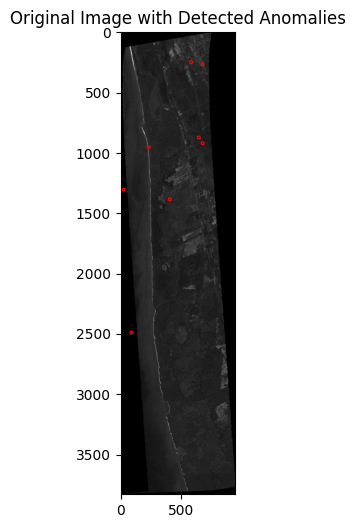

In [41]:
def visualize_anomalies_on_image(image, patch_size, anomaly_indices, image_shape):
    """
    Visualizes the detected anomalies on the original image.

    Parameters:
    - image: The original hyperspectral image (single band or RGB composite).
    - patch_size: Size of each patch (e.g., 16).
    - anomaly_indices: List of indices of detected anomalies (e.g., [983, 3261, 3439, 9026]).
    - image_shape: Shape of the original hyperspectral image (height, width).
    """
    h, w = image_shape[:2]
    
    # Convert anomaly indices to 2D patch locations
    anomaly_positions = []
    for patch_idx in anomaly_indices:
        # Convert the linear index to 2D coordinates
        row = (patch_idx // (w // patch_size)) * patch_size
        col = (patch_idx % (w // patch_size)) * patch_size
        center_x = col + patch_size // 2
        center_y = row + patch_size // 2
        anomaly_positions.append((center_x, center_y))

    plt.figure(figsize=(12, 6))

    # Display the original image (use a representative band, e.g., band 30)
    plt.imshow(image[:, :, 30], cmap='gray')  # Adjust band as needed
    plt.title("Original Image with Detected Anomalies")

    # Plot red circles at the anomaly locations
    ax = plt.gca()
    for (x, y) in anomaly_positions:
        circle = patches.Circle((x, y), radius=patch_size // 3, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(circle)

    plt.show()

# Example usage:
image_shape = sample_image.shape  # Shape of your original hyperspectral image
patch_size = 16  # Adjust based on your patch size
anomaly_indices = close_match_indices  # Use the indices of close matches

# Visualize the anomalies with red circles
visualize_anomalies_on_image(sample_image, patch_size, anomaly_indices, image_shape)

In [45]:
# Define the HDR file parameters
upper_left_easting = 486062.87
upper_left_northing = 3291796.7
pixel_size = 16.8000  # meters
image_samples = 952  # width of the image
image_lines = 3830  # height of the image
patch_size = 1  # Define the patch size if needed

def calculate_geographical_coordinates(anomaly_indices, pixel_size, upper_left_easting, upper_left_northing, image_shape):
    """
    Calculate the geographical coordinates (Easting and Northing) for given anomaly indices.
    
    Parameters:
    - anomaly_indices: List of indices of detected anomalies.
    - pixel_size: Size of each pixel in meters.
    - upper_left_easting: Easting coordinate of the upper left corner.
    - upper_left_northing: Northing coordinate of the upper left corner.
    - image_shape: Shape of the original hyperspectral image (height, width).
    
    Returns:
    - List of tuples containing anomaly index, easting, and northing.
    """
    h, w = image_shape[:2]
    geographical_locations = []

    for idx in anomaly_indices:
        # Calculate the row and column from the anomaly index
        row = idx // w  # Calculate row directly from index
        col = idx % w  # Calculate column directly from index
        
        # Calculate the Easting and Northing coordinates
        easting = upper_left_easting + (col * pixel_size)
        northing = upper_left_northing - (row * pixel_size)  # Subtract because Northing decreases as you go down
        
        geographical_locations.append((idx, easting, northing))

    return geographical_locations

# Example usage:
image_shape = sample_image.shape  # Shape of your original hyperspectral image

# Calculate geographical coordinates for the anomalies based on close matches
geographical_locations = calculate_geographical_coordinates(close_match_indices, pixel_size, upper_left_easting, upper_left_northing, image_shape)

# Print the geographical locations of anomalies
for anomaly_idx, easting, northing in geographical_locations:
    print(f"Anomaly {anomaly_idx + 1}: Easting = {easting:.2f}, Northing = {northing:.2f}")

Anomaly 922: Easting = 501535.67, Northing = 3291796.70
Anomaly 987: Easting = 486634.07, Northing = 3291779.90
Anomaly 3227: Easting = 492278.87, Northing = 3291746.30
Anomaly 3406: Easting = 495286.07, Northing = 3291746.30
Anomaly 3496: Easting = 496798.07, Northing = 3291746.30
Anomaly 4781: Easting = 486398.87, Northing = 3291712.70
Anomaly 5100: Easting = 491758.07, Northing = 3291712.70
Anomaly 9151: Easting = 495840.47, Northing = 3291645.50
